# EMERITUS CAPSTONE PROJECT
**_NUVEEN SALES ANALYSIS:_**
The aim of the project is to build a machine learning model to predict _next year_ sales based on different explanatory variables which describe _current year_ sales.

In the following notebooks, each one of the steps in the Machine Learning model building pipeline are described. There will be a notebook for each one of the Machine Learning Pipeline steps:

1. Exploratory Data Analysis
2. Feature Engineering
3. Feature Selection
4. Model Building

**This is the notebook for step 2: Feature Engineering**

In [17]:
##IMPORTS SECTION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from eda_report import data_report as rp
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [18]:
##LOAD DATASET
df2018 = pd.read_excel('./data/Transaction Data.xlsx',sheet_name='Transactions18')
df2019 = pd.read_excel('./data/Transaction Data.xlsx',sheet_name='Transactions19')
df_dict = pd.read_excel('./data/Data Dictionary.xlsx', usecols = ['Column Name', 'Description'], skiprows = 1)

In [19]:
def var_description(variable):
    idx = df_dict.index.tolist()
    for i in idx:
        if df_dict.iloc[i]['Column Name'] == variable:
            descr = df_dict.iloc[i]['Description']
            break
            
    return descr

After an Exploratory Data Analysis of the datasets it was concluded to perform _Feature Engineering_ techniques as follows:

### Variables preprocessing:

`Preprocessing` refers to the application of **Feature Engineering** techniques in order to treat the variables to be consumed by the Machine Learning model. Next a brief description of the planned techniques to be used.

**AUM Imputation:**
- Using the variables: 'aum_AC_FIXED_INCOME_MUNI', 'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MULTIPLE', 'aum_AC_TARGET', 'aum_P_CEF', 'aum_P_MF' and 'aum_P_SMA', the _Assets-Under-Management_ will be estimated. A KNN model will be used to **impute** the variable.

**Discrete Variables:**
- The variables: 'no_of_sales_12M_1', 'no_of_sales_12M_10K', 'no_of_funds_sold_12M_1', 'no_of_fund_sales_12M_10K', 'no_of_assetclass_sold_12M_1', 'no_of_assetclass_sales_12M_10K', 'No_of_fund_curr', 'No_of_asset_curr', will be treated as `Discrete Variables`. An Encoding tehcnique will be applied to these set of variables.

**Countinuos Variables:**
- The variables: 'AUM', 'sales_curr', 'sales_12M', will be treated as `Continuous Variables`. A Logarithmic Transformation could be applied to these variables in order to "Normalize" its distribution.

***

It is important to split the dataset into `Train` and `Test`, so we can avoid any data leakage, namely we need to apply any of the **Feature Engineering** techniques on our training dataset and after we save any _fitting_ values based on the training dataset, we will apply the same transformations on out test dataset.

**_NOTE_:**

Be aware that **AUM imputation** thru the use of `KNN` will be applied first on the dataset in order to generate a `clean dataset`. Also, all _NaN_ values will be handle first on the dataset as an effort to generate a `clean dataset`, so all **Feature Engineering** techniques will be applied as transformations on a `ML Pipeline`.

## AUM IMPUTATION

During the cleaning data process it is important to check for missing data, if missing data is more than **5%** an imputation technique should be applied to the dataset. `K Nearest Neighbors` can be used as imputation technique in this case.

**_Reference: https://github.com/acadena-repo/MACHINE-LEARNING-TOP-ALGORITHMS-SERIES_**

In [20]:
##LOADING 'AUM' VARIABLES DATASET
aum_col = ['AUM','aum_AC_FIXED_INCOME_MUNI','aum_AC_FIXED_INCOME_TAXABLE','aum_AC_MULTIPLE','aum_AC_TARGET',
           'aum_P_CEF','aum_P_MF','aum_P_SMA']
df_aum = df2018[aum_col]

In [21]:
##OVERRIDE TO ZERO ALL NaN VALUES
df_aum.fillna(0, inplace=True)
df_aum.head(10)

,AUM,aum_AC_FIXED_INCOME_MUNI,aum_AC_FIXED_INCOME_TAXABLE,aum_AC_MULTIPLE,aum_AC_TARGET,aum_P_CEF,aum_P_MF,aum_P_SMA
0,2.374801e+05,284737.930000,84.500,0.00,0.0,0.00,122866.040000,1.146141e+05
1,1.962900e+04,19629.000000,0.000,0.00,0.0,0.00,19629.000000,0.000000e+00
2,1.758700e+03,1758.700000,0.000,0.00,0.0,0.00,1758.700000,0.000000e+00
3,5.794300e+04,0.000000,57943.000,0.00,0.0,0.00,57943.000000,0.000000e+00
4,-8.573590e+03,0.000000,0.000,0.00,0.0,0.00,-8573.590000,0.000000e+00
5,-3.351007e+06,667083.625000,0.000,-2479280.60,0.0,9550.00,255611.950000,-3.616169e+06
6,2.649250e+06,141857.350000,1540006.990,64352.55,0.0,1797990.15,248705.420000,1.291219e+05
7,-4.497203e+05,-753184.580000,0.000,-1397.11,0.0,0.00,-70866.670000,-3.788537e+05
8,-2.086526e+04,3308.273421,0.000,0.00,0.0,0.00,3308.273421,-2.417354e+04
9,-2.713149e+06,-540345.920000,-126895.855,0.00,0.0,0.00,776160.105000,-3.489310e+06


It can be noticed that all negative values are **_"ill"_**, so only the positive `AUM` values will be used for our **KNN** model and negative `AUM` values should be estimated by the model.

In order to build our **KNN** model, positive values are separated and this dataset is used as a _Train_ dataset to fit the **KNN** model.

In [22]:
##KNN MODEL DATASET
knn_model = df_aum.loc[df_aum.AUM > 0.0]
xtrain = knn_model.drop('AUM', axis=1)
ytrain = knn_model['AUM']
##DATASET TO BE IMPUTE
df_impute = df_aum.loc[df_aum.AUM <= 0.0].drop('AUM', axis=1)

In [23]:
##KNN REGRESSOR MODEL
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3)
##FIT MODEL
knn.fit(xtrain, ytrain)
#GET PREDICTIONS
imputed_AUM = knn.predict(df_impute)

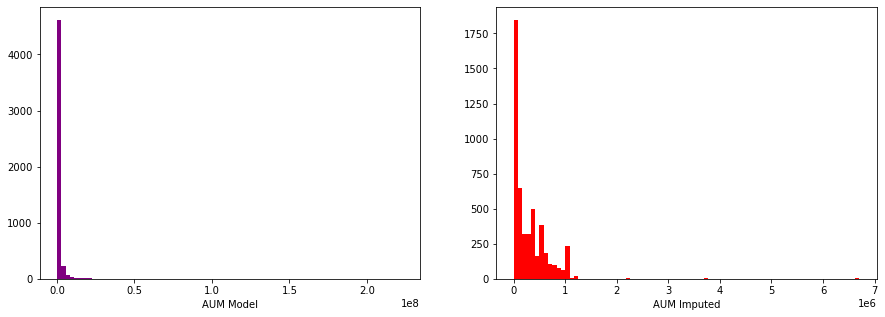

In [24]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(ytrain, bins=80, color='purple')
ax[0].set_xlabel('AUM Model')
ax[1].hist(imputed_AUM, bins=80, color='red')
ax[1].set_xlabel('AUM Imputed')
plt.show()

The `AUM` imputed values will be merge to the original dataset to be used as base on further data preprocessing.

In [25]:
##INDEX VALUES FOR 'AUM' VARIABLE
ipos = knn_model.index.values
ineg = df_impute.index.values
df_pos = pd.DataFrame(ytrain, index=ipos)
df_neg = pd.DataFrame(imputed_AUM, index=ineg, columns=['AUM'])
df2018['AUM'] = pd.concat([df_pos,df_neg], axis=0)

# MERGE AND DATA CLEANING

First, the data from 2019 Transactions are merged with 2018 Transactions due to are those values (2019 Transactions) which are the target's real values that are used as our `Model` validation.

In [26]:
df2019.rename({'sales_12M':'sales_2019', 'new_Fund_added_12M':'Fund_added_2019'}, axis=1, inplace=True)
df2019.drop('refresh_date', axis=1, inplace=True)
##2018 AND 2019 DATASETS ARE MERGE INTO A FULL DATASET
df_full = pd.merge(df2018, df2019, on='CONTACT_ID')

During the Exploratory Data Analysis, the variables that are used to predict the target and those to be discarded were selected.

### Variables to be discard:
- CONTACT_ID: This is not a predictor
- refresh_date: Variable is constant
- no_of_Redemption_12M_1: Collinearity with other variables
- no_of_Redemption_12M_10K: Collinearity with other variables
- no_of_funds_redeemed_12M_1: Collinearity with other variables
- no_of_funds_Redemption_12M_10K: Collinearity with other variables
- no_of_assetclass_redeemed_12M_1: Collinearity with other variables
- no_of_assetclass_Redemption_12M_10K: Collinearity with other variables
- redemption_curr: Variable is not related with Target
- redemption_12M: Variable is not related with Target
- aum_AC_MONEY: Variable is not related with Target and/or AUM
- aum_AC_EQUITY:  Collinearity with other variables
- aum_AC_PHYSICAL_COMMODITY:  Variable is not related with Target and/or AUM
- aum_AC_REAL_ESTATE:  Variable is not related with Target and present collinearity with other variables
- aum_P_529: Variable is not related with Target and/or AUM
- aum_P_ALT: Variable is not related with Target and/or AUM
- aum_P_UCITS: Variable is not related with Target and/or AUM
- aum_P_ETF: Variable is not related with Target and/or AUM
- aum_P_UIT: Variable is not related with Target and/or AUM

Be aware that all variables that start with `aum_` are removed too after the imputation of **AUM** variable.

In [27]:
##VARIABLES SELECTION
col_drop = ['CONTACT_ID','refresh_date','no_of_Redemption_12M_1','no_of_Redemption_12M_10K','no_of_funds_redeemed_12M_1',
            'no_of_funds_Redemption_12M_10K','no_of_assetclass_redeemed_12M_1','no_of_assetclass_Redemption_12M_10K',
            'redemption_curr', 'redemption_12M','aum_AC_MONEY','aum_AC_EQUITY','aum_AC_PHYSICAL_COMMODITY',
            'aum_AC_REAL_ESTATE','aum_P_529','aum_P_ALT','aum_P_UCITS','aum_P_ETF','aum_P_UIT','aum_AC_FIXED_INCOME_MUNI',
            'aum_AC_FIXED_INCOME_TAXABLE','aum_AC_MULTIPLE','aum_AC_TARGET','aum_P_CEF','aum_P_MF','aum_P_SMA']

def keep_columns(df):
    '''Return a dataframe without all removed variables'''
    col_keep = [var for var in df.columns if var not in col_drop]
    return df[col_keep]


In [28]:
##CLEAN DATASET
df_clean = keep_columns(df_full).fillna(0)
df_clean['sales_total'] = df_clean['sales_12M'] + df_clean['sales_curr']
df_clean.describe()

,no_of_sales_12M_1,no_of_sales_12M_10K,no_of_funds_sold_12M_1,no_of_fund_sales_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_sales_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M,new_Fund_added_12M,sales_2019,Fund_added_2019,sales_total
count,10005.000000,10005.000000,10005.00000,10005.000000,10005.000000,10005.000000,10005.000000,10005.000000,1.000500e+04,1.000500e+04,1.000500e+04,10005.000000,1.000500e+04,10005.000000,1.000500e+04
mean,20.082159,2.420090,1.35992,0.570315,0.786207,0.378711,2.144128,0.920040,6.364422e+05,1.728006e+04,1.730879e+05,0.492554,2.140082e+05,0.434983,1.903679e+05
std,98.440409,14.534801,2.37988,1.329914,1.004772,0.709088,3.136572,1.042386,2.983358e+06,1.941043e+05,1.129625e+06,1.199372,1.155079e+06,1.111216,1.208169e+06
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e-02,-1.340539e+05,-3.518727e+04,0.000000,-1.495182e+04,0.000000,-3.518727e+04
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,5.873118e+04,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,1.618481e+05,0.000000e+00,0.000000e+00,0.000000,8.989000e+01,0.000000,0.000000e+00
75%,8.000000,1.000000,2.00000,1.000000,1.000000,1.000000,3.000000,1.000000,5.142486e+05,0.000000e+00,3.155719e+04,1.000000,4.527995e+04,1.000000,3.749675e+04
max,4395.000000,986.000000,32.00000,19.000000,5.000000,5.000000,32.000000,6.000000,2.232411e+08,9.639535e+06,5.434650e+07,16.000000,4.867638e+07,20.000000,5.742647e+07


It can be noticed that `sales` variables have negative values. This is an **"ill"** condition, so all these values will be overridden to zero.

In [29]:
col_sales = [col for col in df_clean.columns if col.lower().startswith('sales_')] #+ ['AUM']

for var in col_sales:    
    df_clean[var] = df_clean[var].apply(lambda x: x if x >= 0.0 else 0.0)
    
df_clean[col_sales].describe()

,sales_curr,sales_12M,sales_2019,sales_total
count,1.000500e+04,1.000500e+04,1.000500e+04,1.000500e+04
mean,1.729354e+04,1.730954e+05,2.140098e+05,1.903744e+05
std,1.940985e+05,1.129624e+06,1.155079e+06,1.208168e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,8.989000e+01,0.000000e+00
75%,0.000000e+00,3.155719e+04,4.527995e+04,3.749675e+04
max,9.639535e+06,5.434650e+07,4.867638e+07,5.742647e+07


This dataset will be saved and it will be used as the starting point to performe our **Feature Engineering** process.

In [30]:
no_sales = df_clean[df_clean['sales_2019']==0]
do_sales = df_clean[df_clean['sales_2019']!=0]

In [31]:
no_sales.describe()

,no_of_sales_12M_1,no_of_sales_12M_10K,no_of_funds_sold_12M_1,no_of_fund_sales_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_sales_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M,new_Fund_added_12M,sales_2019,Fund_added_2019,sales_total
count,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,4935.000000,4.935000e+03,4935.0,4.935000e+03,4935.000000,4935.0,4935.000000,4.935000e+03
mean,1.440729,0.408511,0.246809,0.085309,0.204053,0.074164,1.018034,0.559473,3.102957e+05,0.0,2.744155e+04,0.107194,0.0,0.000608,2.744140e+04
std,22.990747,14.178279,0.719099,0.398895,0.488937,0.287158,1.691283,0.791920,6.541415e+05,0.0,7.230287e+05,0.472231,0.0,0.031828,7.230287e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e-02,0.0,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.167555e+04,0.0,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.131414e+05,0.0,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.113307e+05,0.0,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00
max,1457.000000,986.000000,13.000000,12.000000,4.000000,3.000000,15.000000,5.000000,2.018068e+07,0.0,4.928852e+07,11.000000,0.0,2.000000,4.928852e+07


In [32]:
do_sales.describe()

,no_of_sales_12M_1,no_of_sales_12M_10K,no_of_funds_sold_12M_1,no_of_fund_sales_12M_10K,no_of_assetclass_sold_12M_1,no_of_assetclass_sales_12M_10K,No_of_fund_curr,No_of_asset_curr,AUM,sales_curr,sales_12M,new_Fund_added_12M,sales_2019,Fund_added_2019,sales_total
count,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5.070000e+03,5.070000e+03,5.070000e+03,5070.000000,5.070000e+03,5070.000000,5.070000e+03
mean,38.227219,4.378107,2.443393,1.042406,1.352860,0.675148,3.240237,1.271006,9.539043e+05,3.412660e+04,3.148709e+05,0.867653,4.223211e+05,0.857791,3.489689e+05
std,133.950496,14.611374,2.879964,1.698170,1.052923,0.856660,3.767702,1.133228,4.116394e+06,2.716210e+05,1.403125e+06,1.528592,1.595354e+06,1.439958,1.523450e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.485000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e-02,0.000000,0.000000e+00
25%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,6.661375e+04,0.000000e+00,2.243650e+02,0.000000,6.468065e+03,0.000000,6.031725e+02
50%,7.000000,0.000000,2.000000,0.000000,1.000000,0.000000,2.000000,1.000000,2.052180e+05,0.000000e+00,2.000000e+04,0.000000,4.355179e+04,0.000000,2.400979e+04
75%,27.000000,3.000000,3.000000,1.000000,2.000000,1.000000,5.000000,2.000000,6.948176e+05,2.790697e+03,1.599373e+05,1.000000,2.485290e+05,1.000000,1.789316e+05
max,4395.000000,330.000000,32.000000,19.000000,5.000000,5.000000,32.000000,6.000000,2.232411e+08,9.639535e+06,5.434650e+07,16.000000,4.867638e+07,20.000000,5.742647e+07


In [33]:
df_clean.to_csv('./data/Nuveen Dataset.csv', index_label=False)
# no_sales.to_csv('./data/Nuveen Zero.csv', index_label=False)
# do_sales.to_csv('./data/Nuveen Sales.csv', index_label=False)

# FEATURE ENGINEERING

In [43]:
from sklearn.model_selection import train_test_split

df_nuveen = pd.read_csv('./data/Nuveen Dataset.csv')
X = df_nuveen.drop(['sales_12M','new_Fund_added_12M','sales_2019','Fund_added_2019'], axis=1)
yreg = df_nuveen['sales_2019']
ycls = df_nuveen['Fund_added_2019']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, yreg, test_size=0.3, random_state=5)
print('Train size:',X_train.shape)
print('Test size:',X_test.shape)

Train size: (7003, 10)
Test size: (3002, 10)


## DISCRETE VARIABLES

During the EDA process the variables:
- 'no_of_sales_12M_1'
- 'no_of_sales_12M_10K'
- 'no_of_funds_sold_12M_1'
- 'no_of_fund_sales_12M_10K'
- 'no_of_assetclass_sold_12M_1'
- 'no_of_assetclass_sales_12M_10K'
- 'No_of_fund_curr'
- 'No_of_asset_curr'

Were categorized as discrete variables.

Lets start an analysis and Feature Engineering of these variables.

First, we're going to check the amount of categories that each variable has.

In [45]:
discrete = ['no_of_sales_12M_1','no_of_sales_12M_10K','no_of_funds_sold_12M_1','no_of_fund_sales_12M_10K',
            'no_of_assetclass_sold_12M_1','no_of_assetclass_sales_12M_10K','No_of_fund_curr','No_of_asset_curr']

df_dis = X_train[discrete]
for var in discrete:
    print('Variable Name: {}'.format(var),', Cardinality:',df_dis[var].nunique())

Variable Name: no_of_sales_12M_1 , Cardinality: 286
Variable Name: no_of_sales_12M_10K , Cardinality: 84
Variable Name: no_of_funds_sold_12M_1 , Cardinality: 23
Variable Name: no_of_fund_sales_12M_10K , Cardinality: 14
Variable Name: no_of_assetclass_sold_12M_1 , Cardinality: 6
Variable Name: no_of_assetclass_sales_12M_10K , Cardinality: 5
Variable Name: No_of_fund_curr , Cardinality: 28
Variable Name: No_of_asset_curr , Cardinality: 7


The variables:
- no_of_sales_12M_1
- no_of_sales_12M_10K
- No_of_fund_curr
- no_of_funds_sold_12M_1

Present **high cardinality** which can create problems during the _learning_ process due to overfitting. Also, there is a risk that during the Training and Test split only some of the variables only appear in the Training dataset and not in the Test dataset and viceversa.

An encoding technique know as **Rare Labels** finds a way to gruop several categories that appear in a low proportion under a new category, reducing the cardinality and also, providing a solution to handle categories that are not seen during the training process.

It is common practice to group under the new category, variables with a proportion less than **_5%_** in the observations. Then an anaysis on each variables needs to be performed to find out which of the categories lay on this situation.

Number of Unique Categories:42, Threshold:3[%]


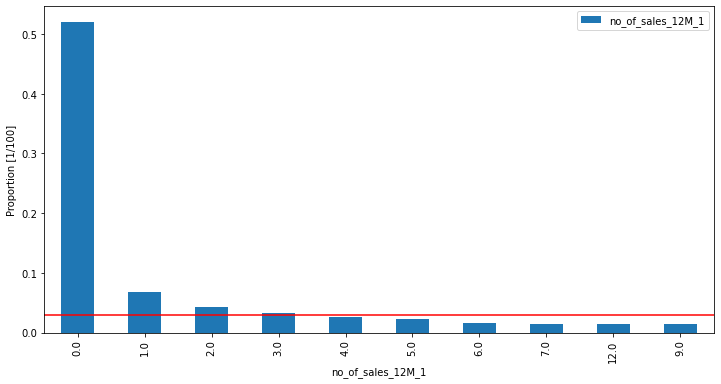

Number of Unique Categories:30, Threshold:3[%]


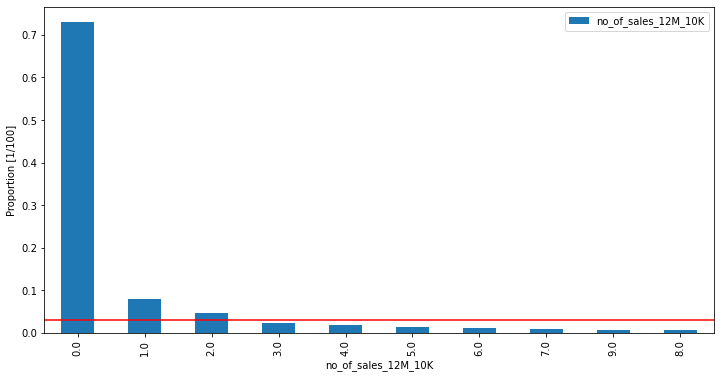

Number of Unique Categories:18, Threshold:3[%]


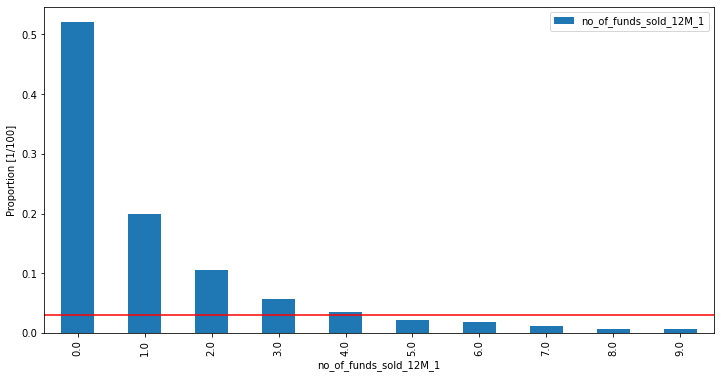

Number of Unique Categories:13, Threshold:3[%]


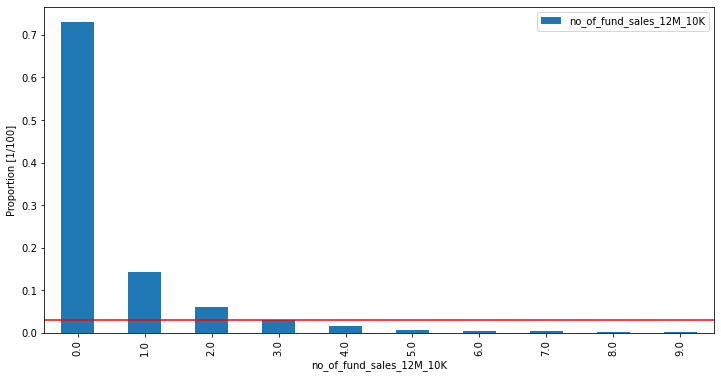

Number of Unique Categories:6, Threshold:3[%]


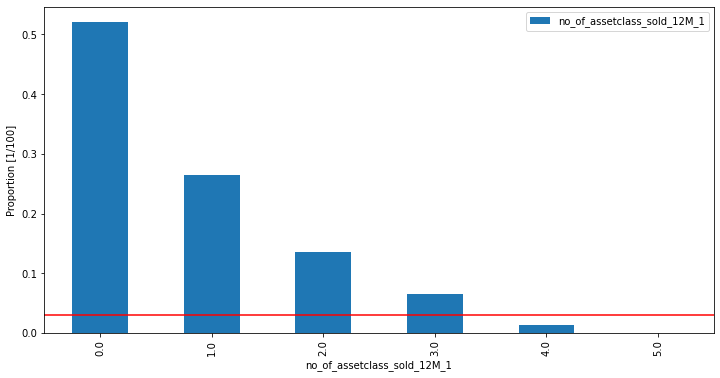

Number of Unique Categories:5, Threshold:3[%]


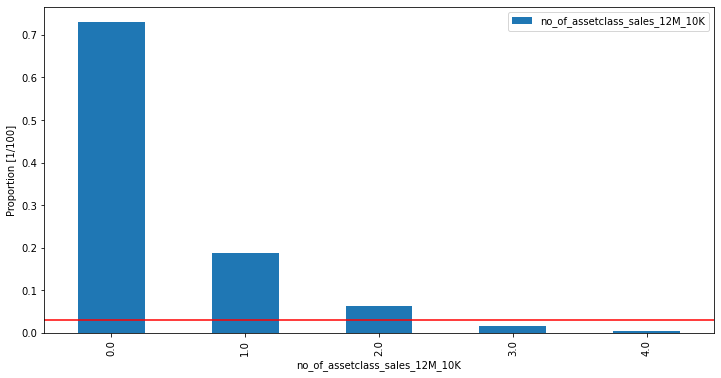

Number of Unique Categories:21, Threshold:3[%]


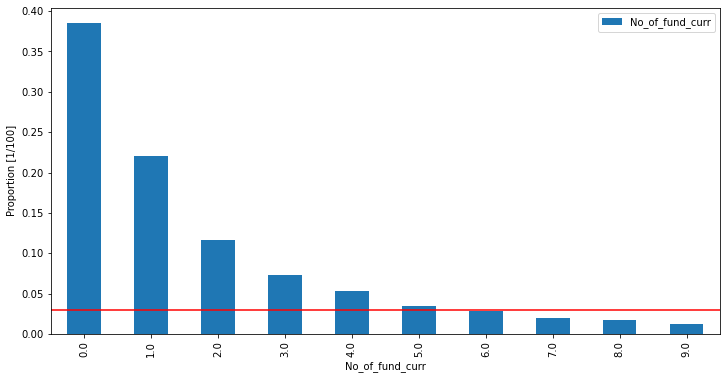

Number of Unique Categories:7, Threshold:3[%]


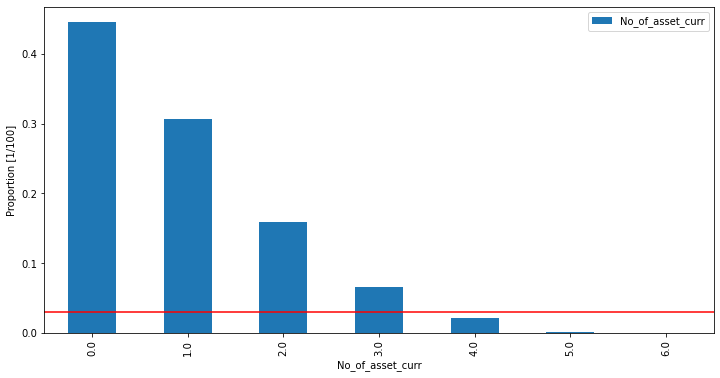

In [46]:
for var in discrete:
    temp = df_dis.groupby(var)[[var]].count()/len(df_dis)
    print('Number of Unique Categories:{0}, Threshold:{1}[%]'.format(temp[var].nunique(), 3))
    fig = temp.nlargest(10,var).plot(kind='bar',figsize=(12,6))
    fig.axhline(y=0.03, color='red')
    fig.set_ylabel('Proportion [1/100]')
    plt.show();

The plots above show the 10 largest categories and a threshold that stablish the minimun value that each category must apport in the overall. This threshold can be used to separate the catogories that shoud be grouped as **rare**.

The next bucket number on each variable will be used to group the **rare** categories. For example, if the last category above the threshold is 4, then the **rare** category group will be set as 5.

In [47]:
def freq_categories(df, variable, threshold):
    temp = df.groupby([variable])[variable].count()/len(df)
    cat = [x for x in temp.loc[temp > threshold].index.values]
    return cat

In [48]:
def rare_encoding(data, variable, encoder, threshold):
    X = data.copy()
    ##FIND FREQUENT CATEGORIES
    freq_cat = freq_categories(encoder, variable, threshold)
    next_cat = freq_cat[-1] + 1
    ##GROUP UNDER 'RARE' LABELS
    X[variable] = np.where(X[variable].isin(freq_cat), X[variable], next_cat)
    
    return X

In [49]:
for var in discrete:
    df_dis = rare_encoding(df_dis, var, X_train, 0.03)
    print('Variable Name: {}'.format(var),', Cardinality:',df_dis[var].nunique())

Variable Name: no_of_sales_12M_1 , Cardinality: 5
Variable Name: no_of_sales_12M_10K , Cardinality: 4
Variable Name: no_of_funds_sold_12M_1 , Cardinality: 6
Variable Name: no_of_fund_sales_12M_10K , Cardinality: 4
Variable Name: no_of_assetclass_sold_12M_1 , Cardinality: 5
Variable Name: no_of_assetclass_sales_12M_10K , Cardinality: 4
Variable Name: No_of_fund_curr , Cardinality: 7
Variable Name: No_of_asset_curr , Cardinality: 5


Number of Unique Categories:5, Threshold:3[%]


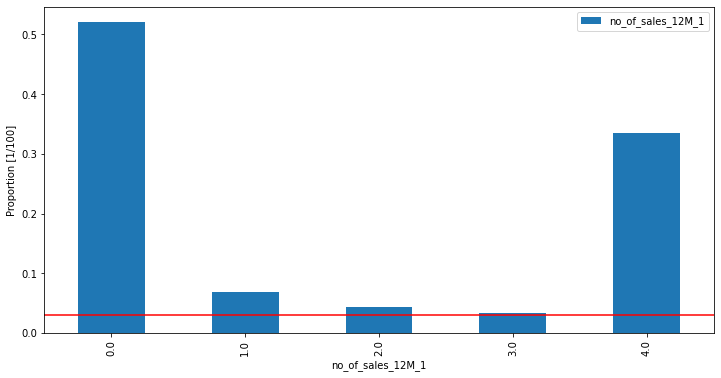

Number of Unique Categories:4, Threshold:3[%]


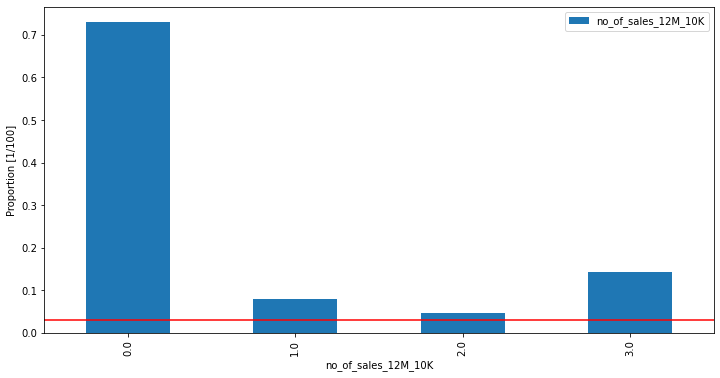

Number of Unique Categories:6, Threshold:3[%]


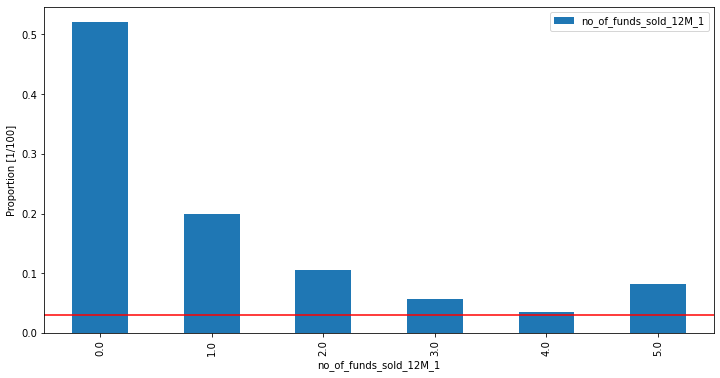

Number of Unique Categories:4, Threshold:3[%]


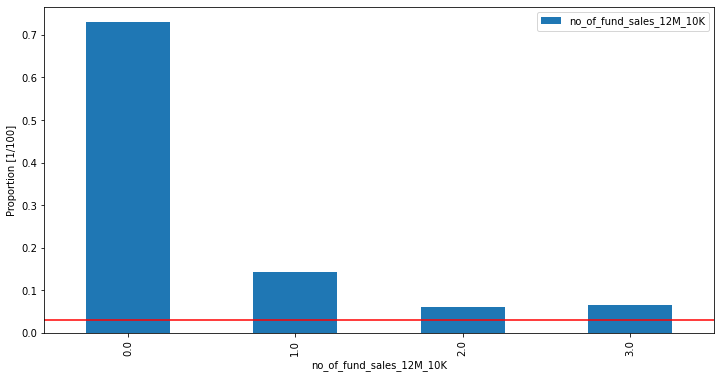

Number of Unique Categories:5, Threshold:3[%]


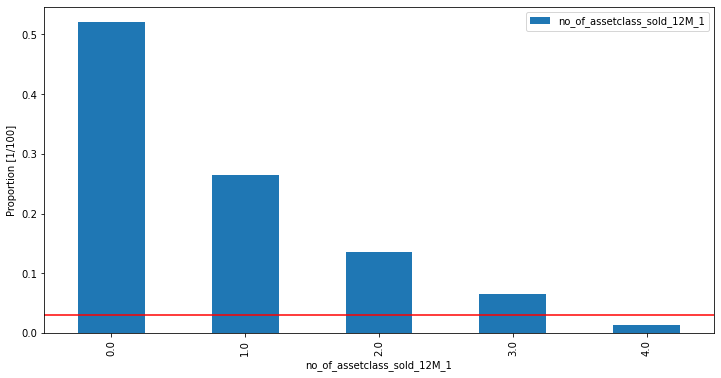

Number of Unique Categories:4, Threshold:3[%]


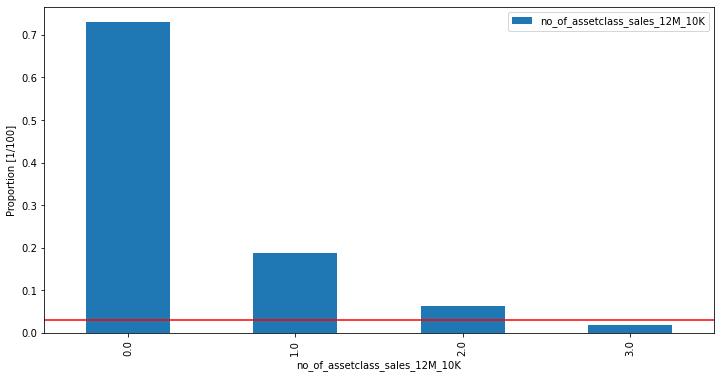

Number of Unique Categories:7, Threshold:3[%]


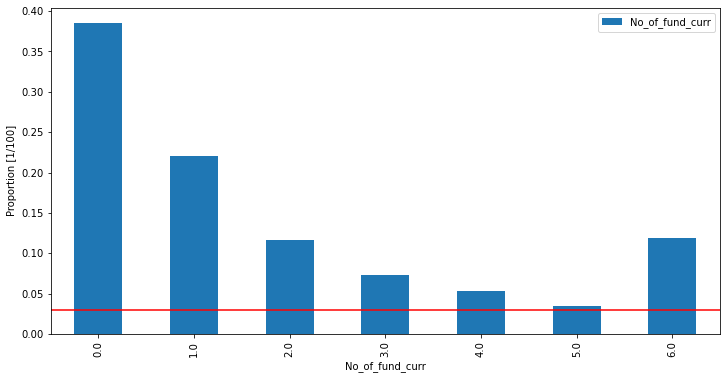

Number of Unique Categories:5, Threshold:3[%]


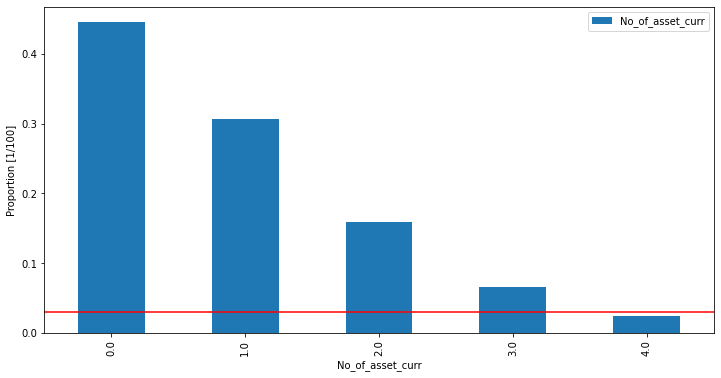

In [50]:
for var in discrete:
    temp = df_dis.groupby(var)[[var]].count()/len(df_dis)
    print('Number of Unique Categories:{0}, Threshold:{1}[%]'.format(temp[var].nunique(), 3))
    fig = temp.plot(kind='bar',figsize=(12,6))
    fig.axhline(y=0.03, color='red')
    fig.set_ylabel('Proportion [1/100]')
    plt.show();

After applying the **Rare Label** encoding technique it can be notice that the cardinality has been reduced dramatically.

Now with fewer categories, each category can be re-arranged in order to get a **monotonic** relationship with the target thru a **Mean** encoding.

Establishing a **monotonic** relationship can improve the performance of certain models such as `Linear Models` which are normally used for regression problems.

First, we going to check the relationship of each discrete variable with the mean target variable.

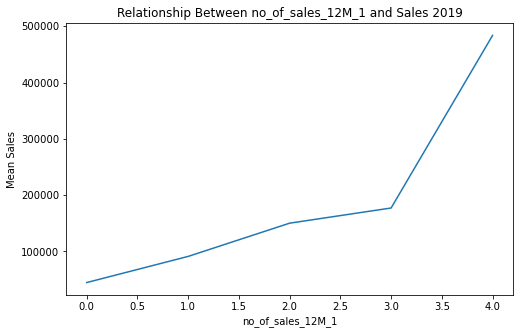

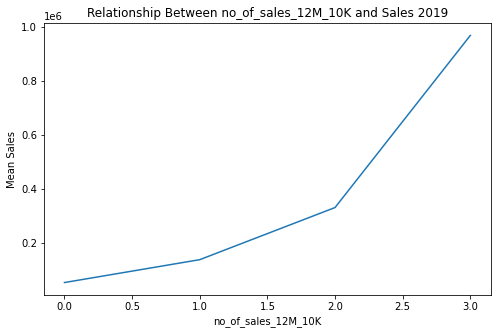

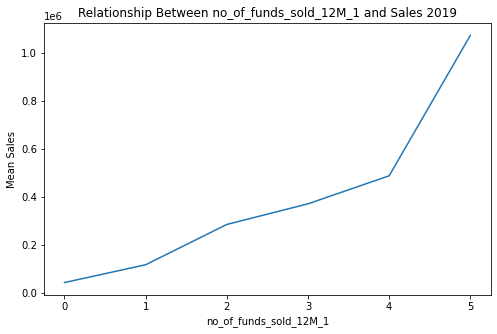

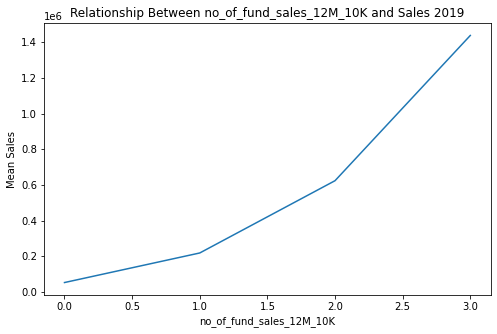

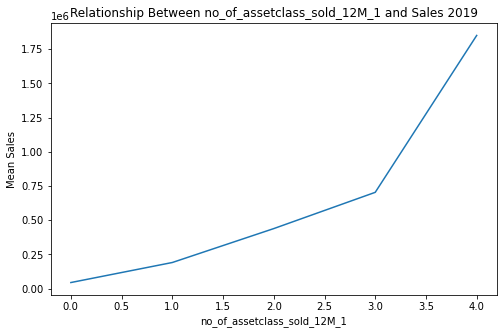

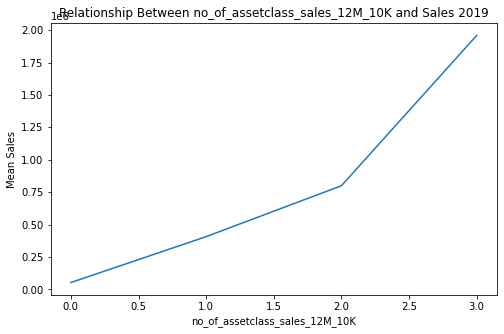

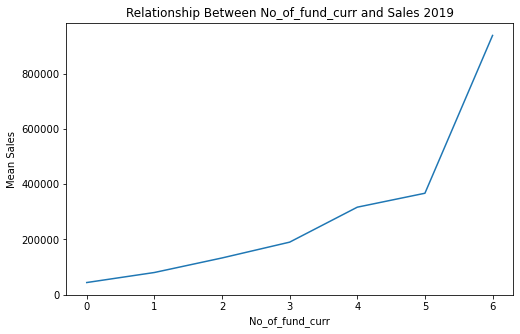

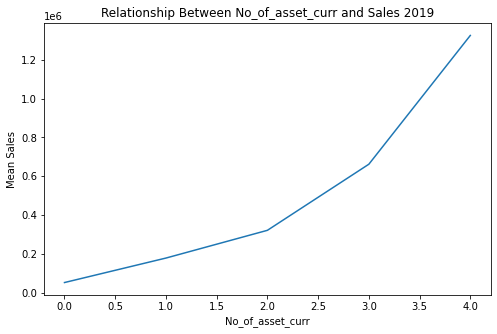

In [51]:
df_rel = pd.concat([df_dis,y_train], axis=1)
for var in discrete:
    fig = df_rel.groupby(var)['sales_2019'].mean().plot(figsize=(8,5))
    fig.set_title('Relationship Between {} and Sales 2019'.format(var))
    fig.set_ylabel('Mean Sales')
    plt.show();

All variables maintain a **monotonic** relationship with the target, so no need to re-arrange the categories.

## CONTINUOUS VARIABLES

During the EDA process the variables:
- 'sales_12M'
- 'sales_curr'
- 'AUM'

Were categorized as continuous variables.

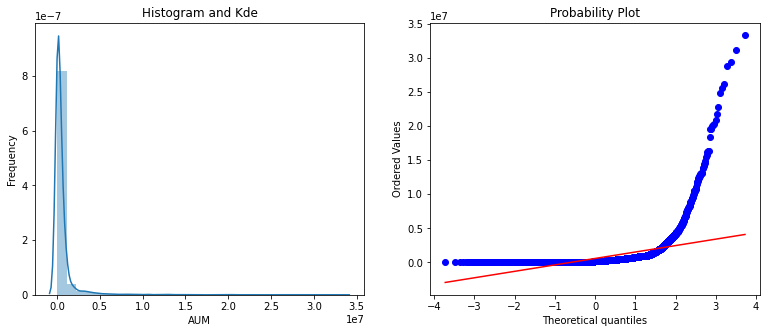

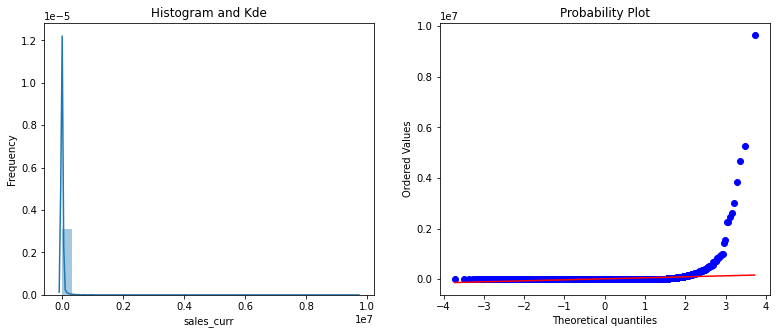

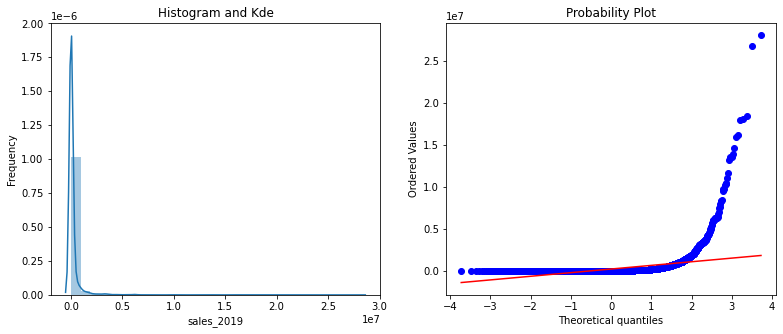

In [52]:
df_con = pd.concat([X_train[['AUM','sales_curr']], y_train], axis=1)

for var in df_con.columns:
    rp.univar_plot(df_con[var])

The three continuous variables are not _Normal_, so a technique should be applied in order to get a better distribution. Typically a mathematic transformation is applied to _"fix"_ the distribution.

The most used mathematical transformation is the **Logaritmic** transformation. It can be noticed that variables have a lot of observations with zero value, so a $log(x + 1)$ function will be applied.

In [53]:
def log_transform(df,variable):
    var = df.copy()
    var[variable] = np.log1p(var[variable])
    
    return df[variable]

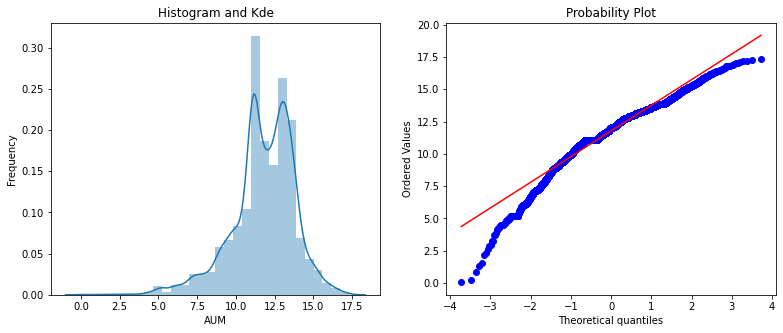

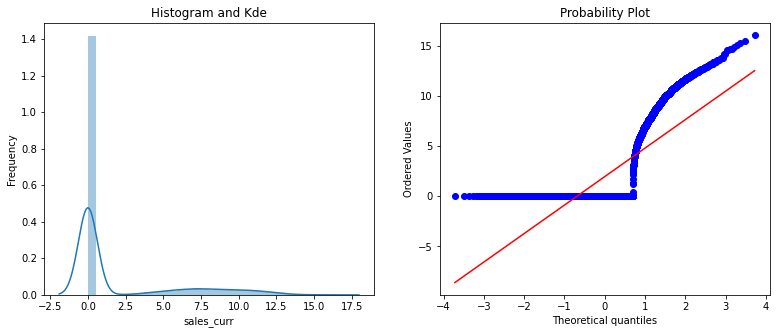

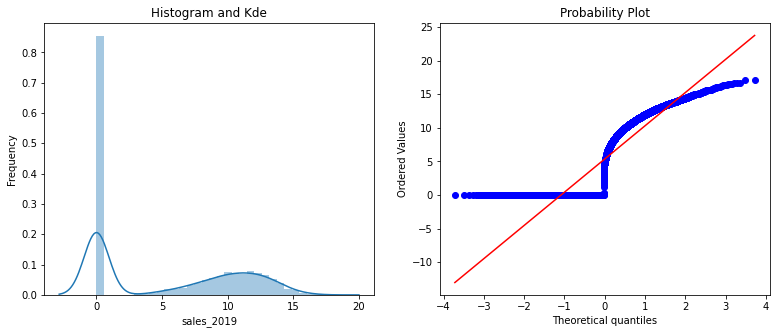

In [54]:
for var in ['AUM','sales_curr','sales_2019']:
    df_con[var] = np.log1p(df_con[var])
    rp.univar_plot(df_con[var])
    

It can be notice that after the logaritmic transformation the variables still show distributions that are **not normal**. Furthermore, the variables show extreme values that can be seen as _outliers_, so a technique that handle outliers need to be applied due to those can create issues for some models such as `Linear Models`.

Discretization is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range of the variable's values.

Discretization helps handle outliers by placing these values into the lower or higher intervals, together with the remaining inlier values of the distribution. Thus, these outlier observations no longer differ from the rest of the values at the tails of the distribution, as they are now all together in the same interval. In addition, by creating appropriate bins or intervals, discretization can help spread the values of a skewed variable across a set of bins with equal number of observations.

After applying discretization a continuous interval is transformed into a set of discrete intervals that span the value range. These intervals can be used as categories and then we can apply any of `categorical encoding` techniques, in fact a very useful way of encoding these intervals is using an encoding that create a **monotonic relationship** of the intervals with the target.

In [85]:
df_bin = pd.concat([X_train[['AUM','sales_curr']], y_train], axis=1)

In [86]:
def discretize_encoder(df, variables, bins, target):
    X = df.copy()
    encoder_dict = {}
    
    for var in variables:
        #Variable Discretization
        X[var] = pd.qcut(X[var],q=bins,labels=False,duplicates='drop')
        #Variable Encoding
        temp = X.groupby(var)[target].mean().sort_values(ascending=True).index
        encoder_dict[var] = {k: i for i,k in enumerate(temp,0)}
        X[var] = X[var].map(encoder_dict[var])
    
    return X  
    

In [87]:
df_bin = discretize_encoder(df_bin,['AUM','sales_curr'],20,'sales_2019')

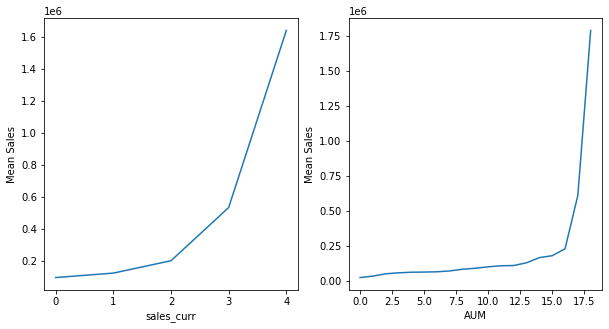

In [94]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
df_bin.groupby('sales_curr')['sales_2019'].mean().plot(ax=ax[0])
ax[0].set_ylabel('Mean Sales')
df_bin.groupby('AUM')['sales_2019'].mean().plot(ax=ax[1])
ax[1].set_ylabel('Mean Sales')
plt.show();